# Clean!!!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from behavelet import wavelet_transform
from sklearn.decomposition import PCA 

# K-MEAN
from sklearn.cluster import KMeans
# GMM clustering
from sklearn import mixture
#correlation
import seaborn as sns

C:\Users\Haha\anaconda3\lib\site-packages\behavelet\morlet.py:26: UserWarning: CuPy was not found, so GPU functionality is unavailable. See https://github.com/cupy/cupy#installation for installation instructions
  warnings.warn('CuPy was not found, so GPU functionality is unavailable. '


# Loading the behavioural/neural data

In [2]:
beh_data_dir = "data/COBAR_behaviour_incl_manual_corrected.pkl"
beh_df = pd.read_pickle(beh_data_dir)


In [3]:
neural_data_dir = beh_data_dir = "data/COBAR_neural.pkl"
neural_df = pd.read_pickle(neural_data_dir)


## Part 2: Data pre-processing

### 1. ΔF/F

In [4]:
#Δ𝐹/𝐹 = (F − Fb)/𝐹b , where Fb is the baseline fluorescence.
# return baselined neural data
def neural_dF_F(data):
    rlt_Df_f=data.copy()
    nb_neurons = np.size(data,1)
    
    for j in np.arange(nb_neurons-1): 
        baseline = data['neuron_' + str(j)].rolling(window=3).mean()
        rlt_Df_f['neuron_' + str(j)] = (data['neuron_' + str(j)]-abs(baseline.min()))/abs(baseline.min())
    return rlt_Df_f

### 2. Noise reduction

In [5]:
from scipy.signal import butter, filtfilt
def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data, axis=0)
    return y

#filter angles in beh data
fs=100.0
order=2
cutoff=20
filtered_beh_df = beh_df.copy(deep=True)
angl=beh_df.filter(regex="angle")
filtered_angl = butter_lowpass_filter(angl, cutoff, fs, order)
filtered_beh_df.iloc[:,2:44]=filtered_angl
#filter neurons reading in neural data
filtered_neural_df = neural_df.copy(deep=True) #necessary to deep copy dataaframe
fs=16.0
order=2
cutoff=2.5
neurons=neural_df.filter(regex="neuron")
filtered_neurons = butter_lowpass_filter(neurons, cutoff, fs, order)
filtered_neural_df.iloc[:,1:124]=filtered_neurons

filtered_neural_df = neural_dF_F(filtered_neural_df)

In [81]:
# Global Parameters
nb_trials = 12
frames_in_trial = 4040

#time vector
t = filtered_neural_df["t"]
time = t[t.index.get_level_values("Trial")==0]
time_offset = time.iloc[-1]
for i in range(nb_trials-1):
    time_trial_i = t[t.index.get_level_values("Trial")==(i+1)]
    time = pd.concat([time, time_trial_i+time_offset], axis=0)
    time_offset = time_offset + time_trial_i.iloc[-1]

# Downsampling manual labels (code provided to us)

In [18]:
# these two functions are just wrappers around the numpy functions to apply them across dimension 0 only
def reduce_mean(values):
    return np.mean(values, axis=0)
def reduce_std(values):
    return np.std(values, axis=0)
def reduce_behaviour(values):
    """
    this is just a sketch for how to reduce behavioural classes. 
    It picks whatever behaviour occurs the most.
    Try to make this more stable, for example by handling the case when two behaviours are equally likely.
    You might also want to include a certainty threshold, 
    e.g. 3/4 of the behaviour frames have to be labelled the same way, otherwise it is None and the data is excluded
    """
    unique_values, N_per_unique = np.unique(values, return_counts=True)
    i_max = np.argmax(N_per_unique)
    return unique_values[i_max]

def reduce_during_2p_frame(twop_index, values, function=reduce_mean):
    """
    Reduces all values occuring during the acquisition of a
    two-photon imaging frame to a single value using the `function` given by the user.
    Parameters
    ----------
    twop_index : numpy array
        1d array holding frame indices of one trial.
    values : numpy array
        Values upsampled to the frequency of ThorSync,
        i.e. 1D numpy array of the same length as
        `frame_counter` or 2D numpy array of the same length.
    function : function
        Function used to reduce the value,
        e.g. np.mean for 1D variables
    Returns
    -------
    reduced : numpy array
        Numpy array with value for each two-photon imaging frame.
    """
    
    if len(twop_index) != len(values):
        raise ValueError("twop_index and values need to have the same length.")
    if len(values.shape) == 1:
        values = np.expand_dims(values, axis=1)
        squeeze = True
    else:
        squeeze = False
    N_samples, N_variables = values.shape
    
    index_unique = np.unique(twop_index)
    index_unique = np.delete(index_unique, index_unique==-9223372036854775808)
    
    dtype = values.dtype
    if np.issubdtype(dtype, np.number):
        dtype = np.float
    else:
        dtype = np.object
    reduced = np.empty((len(index_unique), N_variables), dtype=dtype)

    for i, index in enumerate(index_unique):
        reduced[i] = function(values[twop_index==index, :])

    return np.squeeze(reduced) if squeeze else reduced

In [19]:
# apply downsampling to manual labels
twop_index = beh_df.loc[(210301, "J1xCI9", 1, 0), "twop_index"].to_numpy()
values = beh_df.loc[(210301, "J1xCI9", 1, 0), "Manual"].to_numpy()

reduced_labels = reduce_during_2p_frame(twop_index, values, function=reduce_behaviour)

# Investigate clustering of neurons' activity: find neurons that correlate with each other

This section aims at finding neurons that activate at similar times. This is done by doing a Principal Component Analysis (PCA) followed by clastering. The clastering is then evaluated using inter-neuron correlation.

## PCA 

In [13]:
# Functions required for PCA 

# normalise the data
def normalise(data):
    Feature_scaler = sklearn.preprocessing.StandardScaler().fit(data)
    return sklearn.preprocessing.scale(data)

# apply PCA:  
# input samples: neurons
# input features: time samples
def PCA_temporal(data_norm, time, plot=False):

    pca = PCA(n_components=27)
    data_new = pca.fit_transform(data_norm.T)
    print('Variance explained by first 27 pricipal components:')
    print(pca.explained_variance_ratio_)
    print(sum(pca.explained_variance_ratio_))
    
    if plot:
        #plot loadings
        fig, ax = plt.subplots()
        loadings = pd.DataFrame(pca.components_[0:2].T, columns=['PC1', 'PC2'])
        plt.plot(time, loadings['PC1'], label = 'PC1', alpha=0.5)
        plt.plot(time, loadings['PC2'], label = 'PC2', alpha=0.5)
        plt.title('PCA Loadings of Neural Activity')
        plt.xlabel('Time point [s]')
        plt.ylabel('PCA weight')
        plt.legend()
        plt.show()
        fig.savefig('report_images/pca_neuro_temporal_loadings.png')
        
        fig, ax = plt.subplots()
        #scatter plot of first two components
        plt.scatter(data_new[:,0], data_new[:,1], alpha = 0.5) 
        plt.title('PCA Projected Neurons')
        plt.xlabel('PCA component 1 ({:.2f}%)'.format(100*pca.explained_variance_ratio_[0]))
        plt.ylabel('PCA component 2 ({:.2f}%)'.format(100*pca.explained_variance_ratio_[1]))
        plt.show()
        fig.savefig('report_images/pca_neuro_temporal_scatter.png')
        
    return data_new, pca

Variance explained by first 27 pricipal components:
[0.27332419 0.26424122 0.06765547 0.03619374 0.0326937  0.0254746
 0.02292318 0.01734588 0.01707517 0.01548904 0.01295125 0.01225217
 0.01175104 0.01067083 0.0093881  0.0088493  0.00829768 0.00770564
 0.00727818 0.00614954 0.00559383 0.00521786 0.00487226 0.004508
 0.00438391 0.00417919 0.00379807]
0.9002630493135011


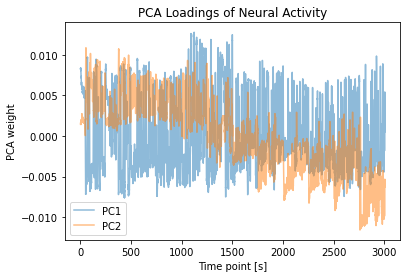

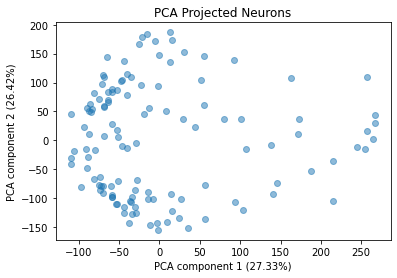

In [14]:
# PCA implementation (all trials are used as data)
X = filtered_neural_df.filter(regex="neuron")

X_norm = normalise(X)
X_new, pca = PCA_temporal(X_norm, time, plot=True)


## clustering
After the dimension reduction done with the PCA, the neurons can be clastered. These clusters represent neurons that have similar signals.

In [46]:
# cluster data using kmeans
# returns the classes and class names
def kmeans_cluster(data, nb_clusters, plot=False):
    
    #fit kmeans
    kmeans = KMeans(n_clusters=nb_clusters, init='random', n_init=1, verbose=0)
    kmeans.fit(data)
    labels = kmeans.labels_
    class_names = np.unique(labels)

    if plot:
        #plot scatter points with colours of KMEANS clusters
        fig, ax = plt.subplots()
        for i in range(len(class_names)):
                select_indices = np.where(labels == class_names[i])
                plt.scatter(data[select_indices,0], data[select_indices,1], alpha = 0.5)  

        plt.xlabel('feature 1')

        plt.ylabel('feature 2')
        plt.title('KMEANS clustering')
        plt.legend(class_names)
        plt.show()
        fig.savefig('report_images/cluster_kmeans.png')
    
    return labels, class_names

# cluster data using GMM
# returns the classes and class names
def GMM_cluster(data, nb_components, plot=False):
    
    # Fit a Gaussian mixture with EM
    gmm = mixture.GaussianMixture(n_components=nb_components, covariance_type='full').fit(data)
    
    labels = gmm.predict(data)
    class_names = np.unique(labels)

    if plot:
        #plot scatter points with colours of GMM clusters
        fig, ax = plt.subplots()
        for i in range(len(class_names)):
                select_indices = np.where(labels == class_names[i])
                plt.scatter(data[select_indices,0], data[select_indices,1], alpha = 0.5)  

        plt.xlabel('feature 1')

        plt.ylabel('feature 2')
        plt.title('GMM clustering')
        plt.legend(class_names)
        plt.show()
        fig.savefig('report_images/cluster_GMM.png')
        
    return labels, class_names

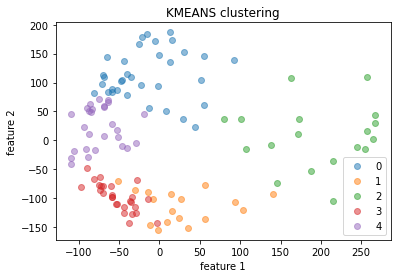

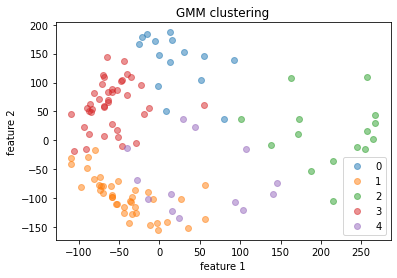

In [59]:
kmeans_labels, kmeans_names = kmeans_cluster(X_new, nb_clusters=5, plot=True)
GMM_labels, GMM_names = GMM_cluster(X_new, nb_components=5, plot=True)

### Neural activity of neurons from the same and different clusters

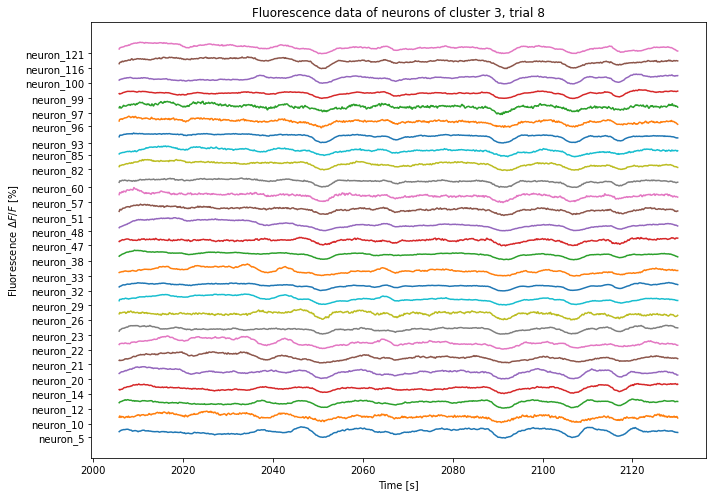

In [93]:
# compare neuronal activity of neurons of the same cluster: trial 8 (first half)
trial = 8
frame_i = int(frames_in_trial*(trial))
frame_f = int(frames_in_trial*(trial+0.5))

fig, ax = plt.subplots(figsize = (10,7))

ytick = []
neurons_cluster = np.where(kmeans_labels == kmeans_names[3])[0]
for i,neuro_id in enumerate(neurons_cluster): 
    neural_signals_neuron_i = X_norm[:,neuro_id]
    #plt.plot(time[time.index.get_level_values("Trial")==8], i*5 + neural_signals_neuron_i[4040*8:4040*9], label = 'neuron_' + str(neuro_id))
    plt.plot(time.iloc[frame_i:frame_f], i*5 + neural_signals_neuron_i[frame_i:frame_f], label = 'neuron_' + str(neuro_id))
    
    #frames_in_trial
    ytick.append(i*5 + neural_signals_neuron_i[0])
    
plt.ylabel('Fluorescence $\Delta F/F$ [%]')
plt.xlabel('Time [s]')
plt.title('Fluorescence data of neurons of cluster 3, trial 8')

plt.yticks(np.array(ytick))
neuron_names = ['neuron_' + str(i) for i in neurons_cluster]
ax.set_yticklabels(neuron_names)

plt.tight_layout()
plt.show()
fig.savefig('report_images/cluster3_signal.png')


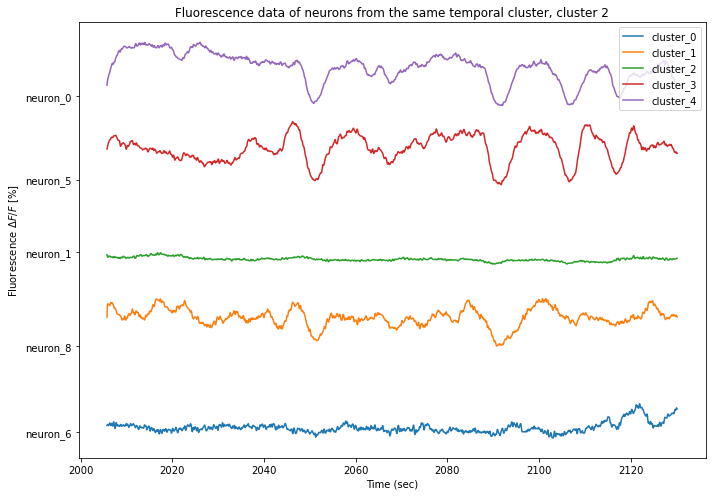

In [96]:
# compare neuronal activity of neurons of different clusters: trial 8
fig, ax = plt.subplots(figsize = (10,7))

ytick = []
neuron_names = []
for i in range(len(kmeans_names)):
    neurons_cluster = np.where(kmeans_labels == kmeans_names[i])[0]
    neural_signals_neuron_i = X_norm[:,neurons_cluster[0]]
    #plt.plot(time[time.index.get_level_values("Trial")==8], i*5 + neural_signals_neuron_i[4040*8:4040*9], label = 'cluster_' + str(i))
    plt.plot(time.iloc[frame_i:frame_f], i*5 + neural_signals_neuron_i[frame_i:frame_f], label = 'cluster_' + str(i))
    
    ytick.append(i*5 + neural_signals_neuron_i[0])
    neuron_names.append('neuron_' + str(neurons_cluster[0]))
    
plt.ylabel('Fluorescence $\Delta F/F$ [%]')
plt.xlabel('Time (sec)')
plt.title('Fluorescence data of neurons from the same temporal cluster, cluster 2')

ax.set_yticks(np.array(ytick))
ax.set_yticklabels(neuron_names)
plt.legend()

plt.tight_layout()
plt.show()
fig.savefig('report_images/clusters_diff_signal.png')

## Correlation
To evaluate the similarity between the signals of neurons from the same cluster, we can find their correlation coefficients.

In [101]:
# plot correlation coefficient of given data
def plot_correlation_coeff(data, title, filename):
    #Set up the matplotlib figure
    fig, ax = plt.subplots(figsize = (15,10))

    #Compute the correlation matrix
    correlation = data

    corr = correlation.corr()

    #Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    #Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    #Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.xlabel('neuron id')
    plt.ylabel('neuron id')
    plt.title(title)
    plt.show()
    fig.savefig('report_images/'+filename+'.png')

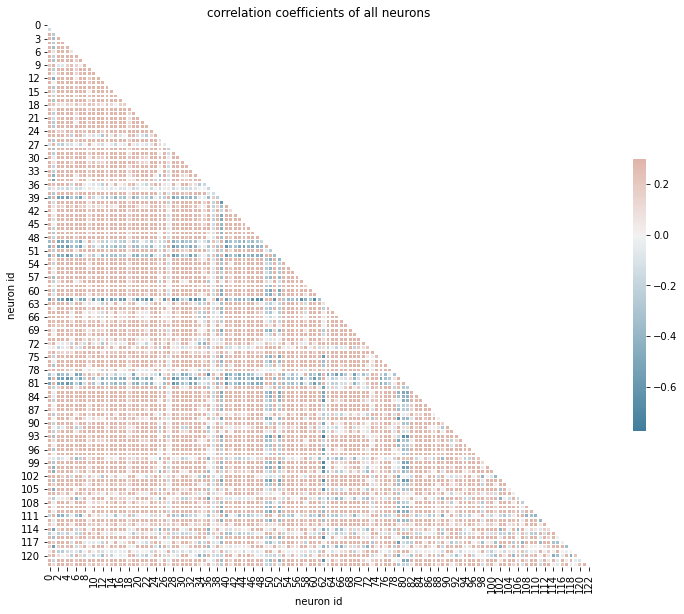

In [108]:
# correlation coefficient of all the neurons
plot_correlation_coeff(pd.DataFrame(data=X_norm), title='correlation coefficients of all neurons', filename='corr_all_neurons')

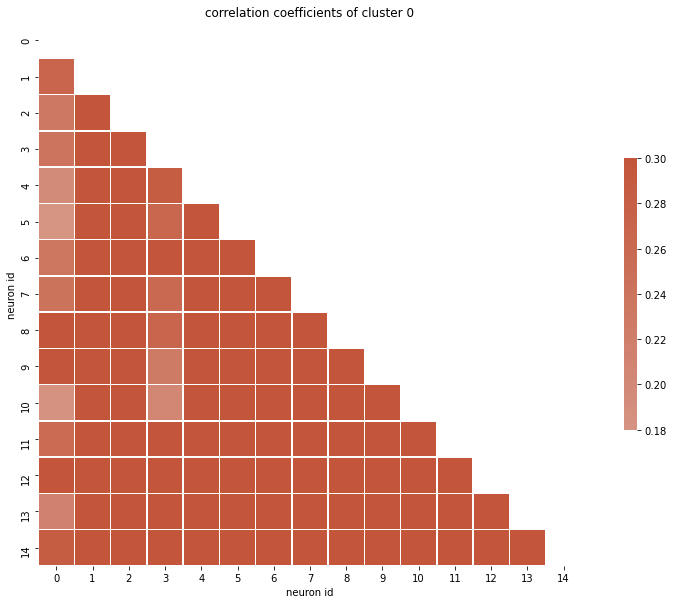

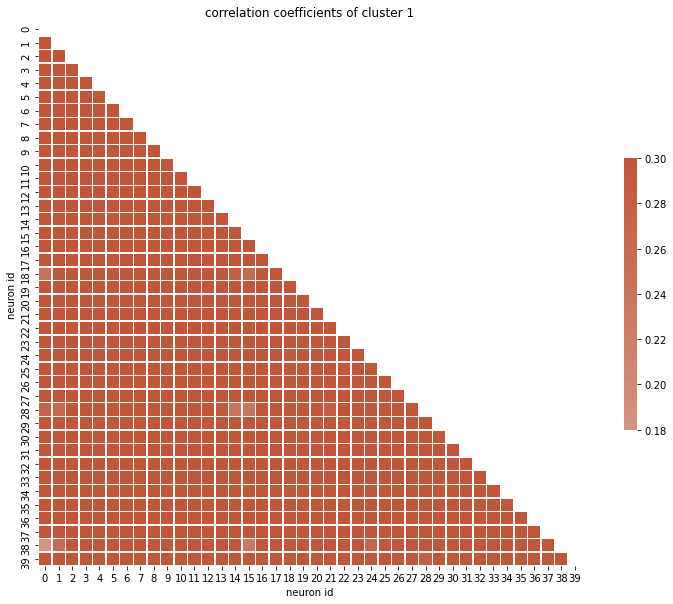

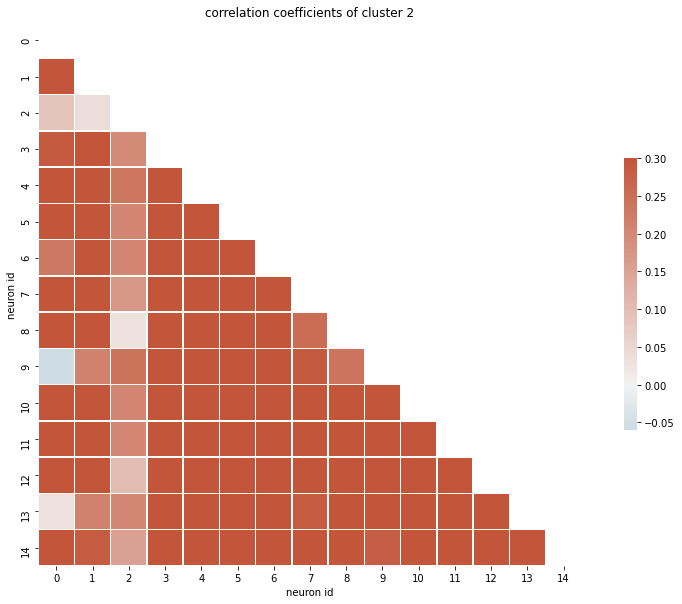

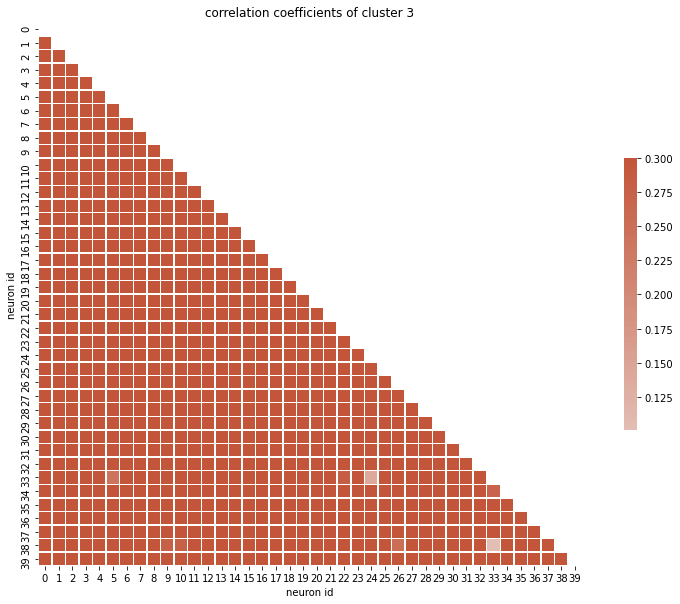

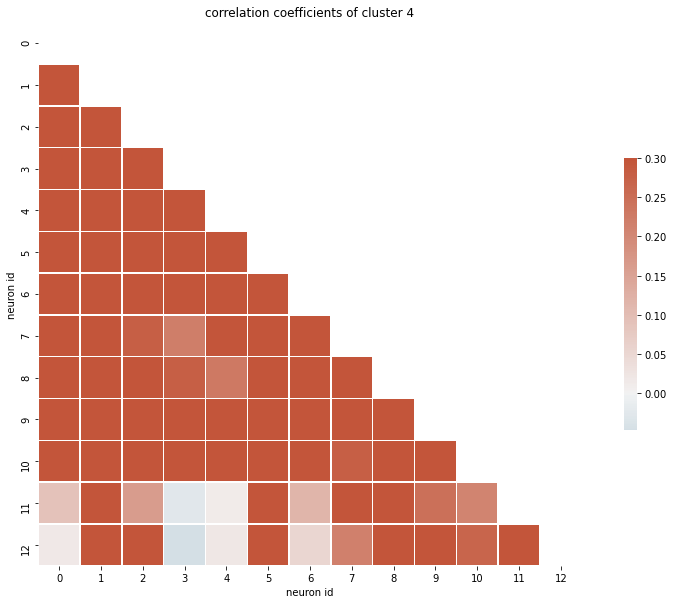

In [107]:
for i in range(len(GMM_names)):  
    neurons_cluster = np.where(GMM_labels == GMM_names[i])[0]
    plot_correlation_coeff(pd.DataFrame(data=X_norm[:,neurons_cluster]), title='correlation coefficients of cluster {}'.format(i),\
                           filename='corr_gmm{}'.format(i))

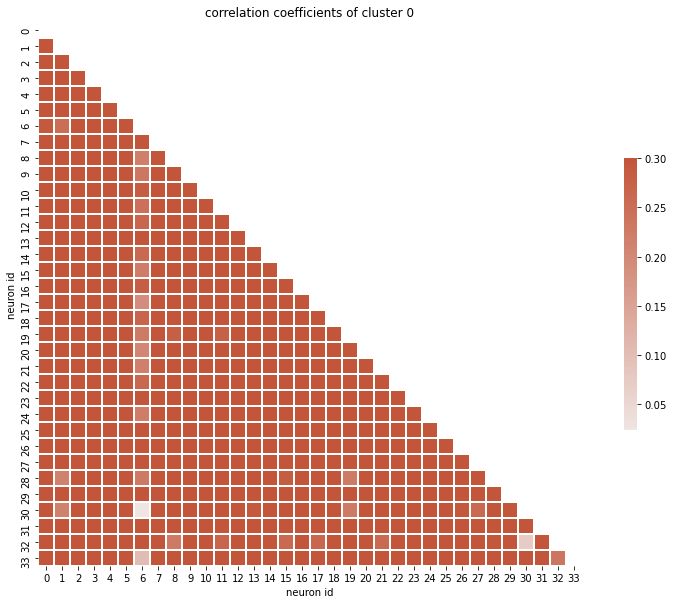

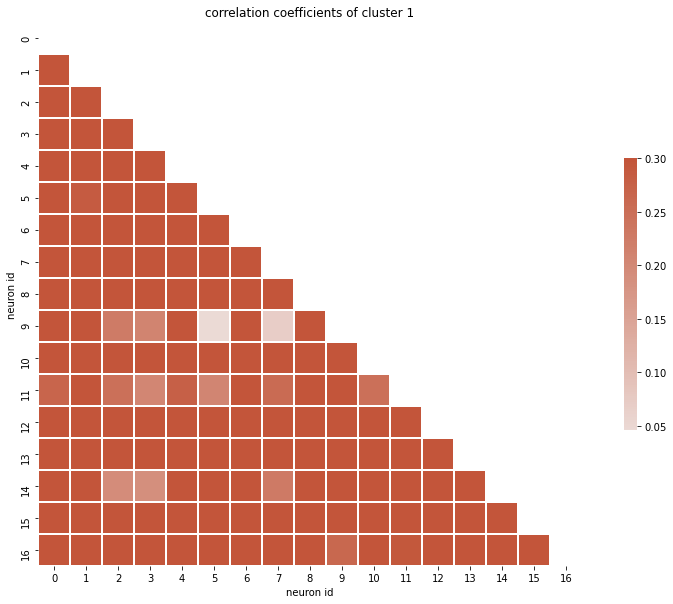

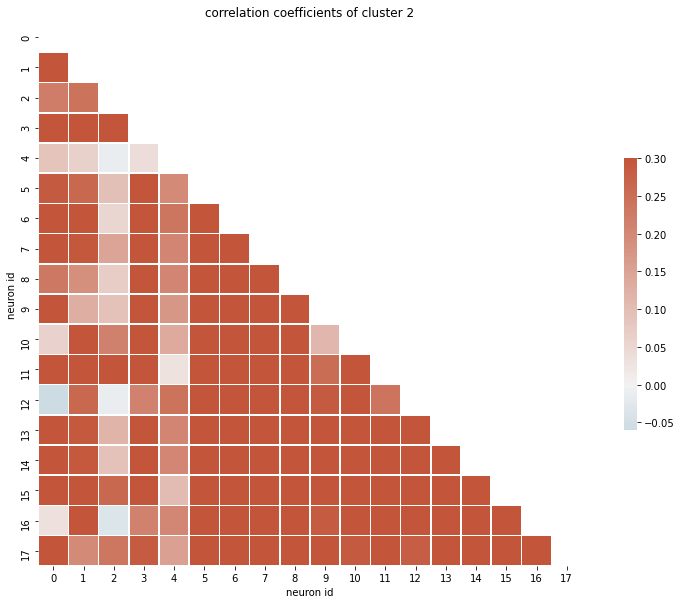

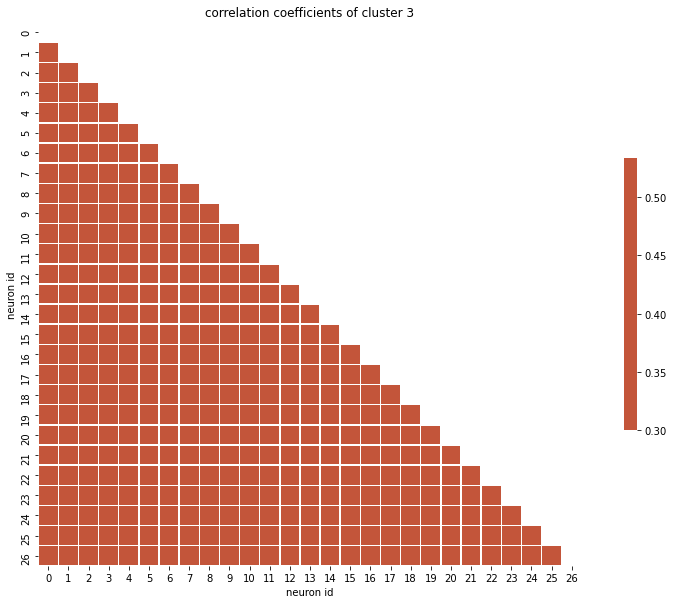

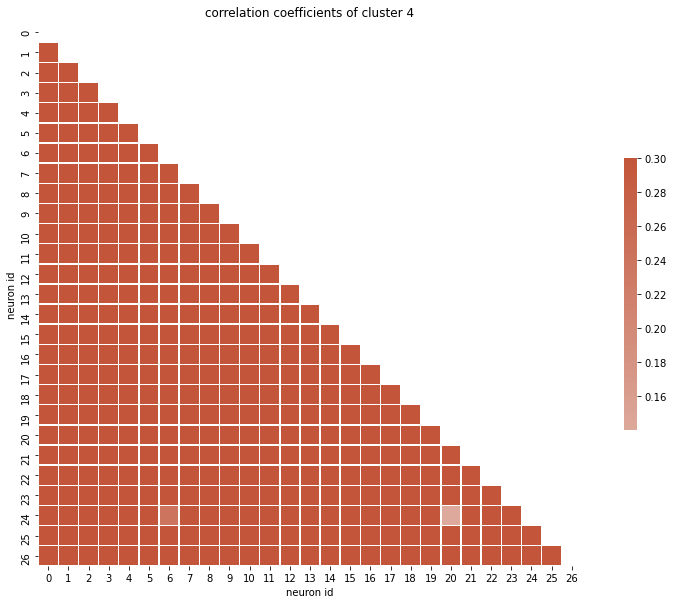

In [106]:

for i in range(len(kmeans_names)):  
    neurons_cluster = np.where(kmeans_labels == kmeans_names[i])[0]
    plot_correlation_coeff(pd.DataFrame(data=X_norm[:,neurons_cluster]), title='correlation coefficients of cluster {}'.format(i),\
                          filename='corr_kmeans{}'.format(i))